# Seq2Seq 기반 챗봇 만들기

> 3. 챗봇 모듈

In [1]:
# 모듈 불러오기
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.layers import Permute, Activation, Dot, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pickle
import numpy as np

from IPython.display import SVG
from keras.utils import model_to_dot

In [2]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"
chatbot_path = f"{root_path}/Seq2Seq-Chatbot"

In [3]:
# 단어 목록
with open(f"{data_path}/6-1.vocabulary.pickle", 'rb') as f:
    word2idx, idx2word = pickle.load(f)

# 학습 데이터: 인코딩, 디코딩 입력, 디코딩 출력
with open(f"{data_path}/6-1.train_data.pickle", 'rb') as f:
    X_train_E, X_train_D, y_train_D = pickle.load(f)

# 테스트 데이터: 인코딩, 디코딩 입력, 디코딩 출력
with open(f"{data_path}/6-1.eval_data.pickle", 'rb') as f:
    X_test_E, X_test_D, y_test_D = pickle.load(f)

## 모델 구성

 학습 모델과 동일하게 구성한다. 모델을 컴파일하여 학습하지 않고, 이미 학습된 모델의 가중치를 가져 온다.

In [4]:
# 모델 파라미터 설정
VOCAB_SIZE = len(idx2word)
EMB_SIZE = int(input('임베딩 출력 차원 설정: '))
LSTM_HIDDEN = int(input('LSTM 은닉 노드 수 설정: '))
MAX_LENGTH = int(input('문장 최대 길이 설정(주의): '))
MODEL_PATH = f"{chatbot_path}/Seq2Seq_attention.h5"

임베딩 출력 차원 설정: 128
LSTM 은닉 노드 수 설정: 128
문장 최대 길이 설정(주의): 10


In [6]:
def Attention(x, y):
    '''
    x: encoder 출력
    y: decoder 출력
    return: concatenated tensors
    '''
    # 1. dot: decoder 매 시점마다 encoder 전체 시점과 dot-product.
    score = Dot(axes=(2,2))([y,x])
    # 2. softmax
    dist = Activation('softmax')(score)
    # 3. 가중평균
    score = Dot(axes=(3, 1))([tf.expand_dims(dist, 0), x])
    # 4. sum
    score = tf.reduce_sum(score, axis=1)
    
    return Concatenate()([score, y]) # 5. concat

In [7]:
# 세션 클리어
K.clear_session()

# 공통 임베딩 레이어
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

In [8]:
# Encoder 네트워크 구성
E_input = Input(batch_shape=(None, MAX_LENGTH))
E_embed = wordEmbedding(E_input)
E_lstm1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
E_lstm2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
ey1, eh1, ec1 = E_lstm1(E_embed)
ey2, eh2, ec2 = E_lstm2(ey1) # 1층의 출력을 받는다

In [9]:
# Decoder 네트워크 구성
D_input = Input(batch_shape=(None, 1))
D_embed = wordEmbedding(D_input)
D_lstm1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
D_lstm2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, dh1, dc1 = D_lstm1(D_embed, initial_state=[eh1, ec1]) # 초기 상태 설정
dy2, dh2, dc2 = D_lstm2(dy1, initial_state=[eh2, ec2]) # 초기 상태 설정

In [10]:
# Attention 네트워크 구성
attention = Attention(ey2, dy2)

In [11]:
# 출력 네트워크
y_output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')) # 시간 분배
y_output = y_output(attention)

========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2650240     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 128), (N 

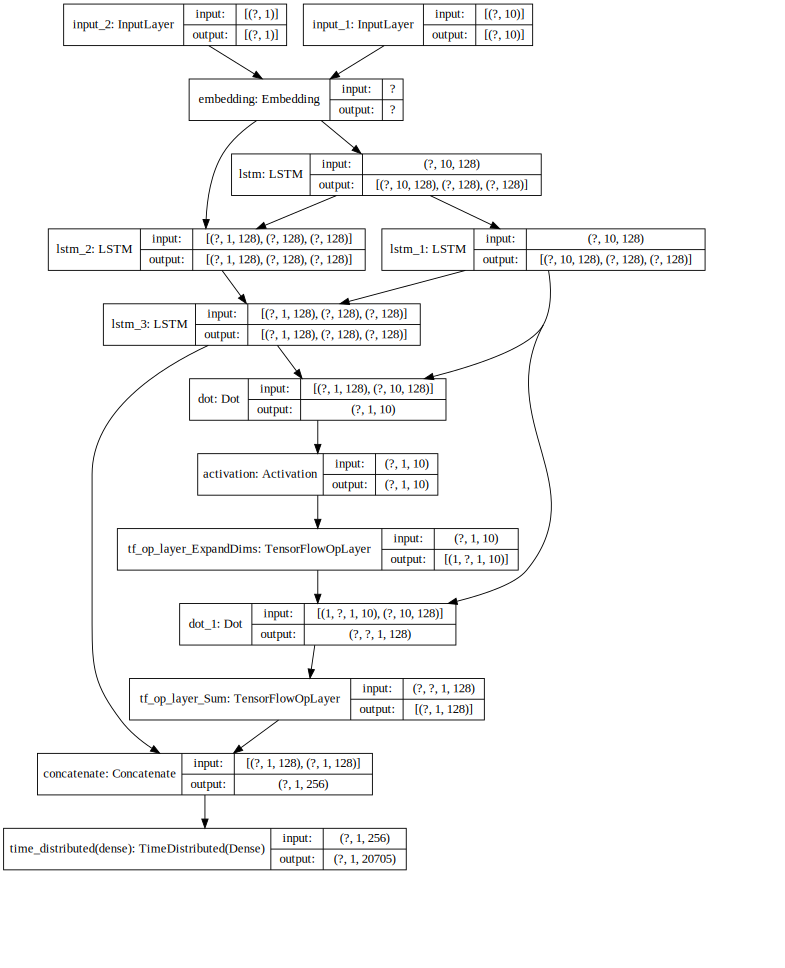

In [12]:
# 모델 구성
model = Model([E_input, D_input], y_output)
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy')
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## Chatting용 모델
- 인코더에 입력하고, 인코더 모델에서의 h, c를 모두 출력한다.
- initial state를 입력받아서 설정한다.
- 디코더 모델에서는 초기 상태를 한 번씩 입력 받고 업데이트하기 위해, 번거롭지만 따로 구성하자.
- 출력은 그대로 넣어주기만 하면 된다.
- 디코더 모델은 다음과 같다.
    - 디코더 입력을 받는다.
    - 업데이트할 가중치도 입력 받는다.
    - 예측치 나오면(y_output) 그걸 다시 넣어서 가중치 업데이ㅡ.

========== 인코더 모델 구조 확인 ==========
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        multiple                  2650240   
_________________________________________________________________
lstm (LSTM)                  [(None, 10, 128), (None,  131584    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 10, 128), (None,  131584    
Total params: 2,913,408
Trainable params: 2,913,408
Non-trainable params: 0
_________________________________________________________________
None


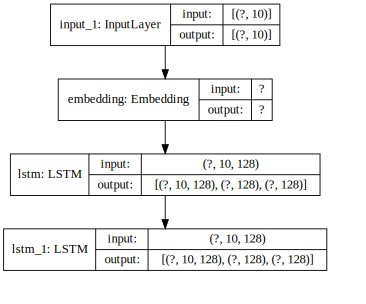

In [13]:
# 인코더 모델
encoder_model = Model(E_input, [eh1, ec1, eh2, ec2, ey2])
print("========== 인코더 모델 구조 확인 ==========")
print(encoder_model.summary())
SVG(model_to_dot(encoder_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [14]:
# initial state 설정용 네트워크
ih1 = Input(batch_shape = (None, LSTM_HIDDEN))
ic1 = Input(batch_shape = (None, LSTM_HIDDEN))
ih2 = Input(batch_shape = (None, LSTM_HIDDEN))
ic2 = Input(batch_shape = (None, LSTM_HIDDEN))
ey = Input(batch_shape=(None, MAX_LENGTH, LSTM_HIDDEN))

In [15]:
# 디코더 모델
dy1, dh1, dc1 = D_lstm1(D_embed, initial_state=[ih1, ic1]) # 초기 상태를 한 번씩 입력받기 위해
dy2, dh2, dc2 = D_lstm2(dy1, initial_state=[ih2, ic2]) # 초기 상태 

In [16]:
# 어텐션
attention = Attention(ey, dy2)

In [17]:
# 출력 네트워크
y_output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')) # 시간 분배
y_output = y_output(attention)

========== 디코더 모델 구조 확인 ==========
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2650240     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________

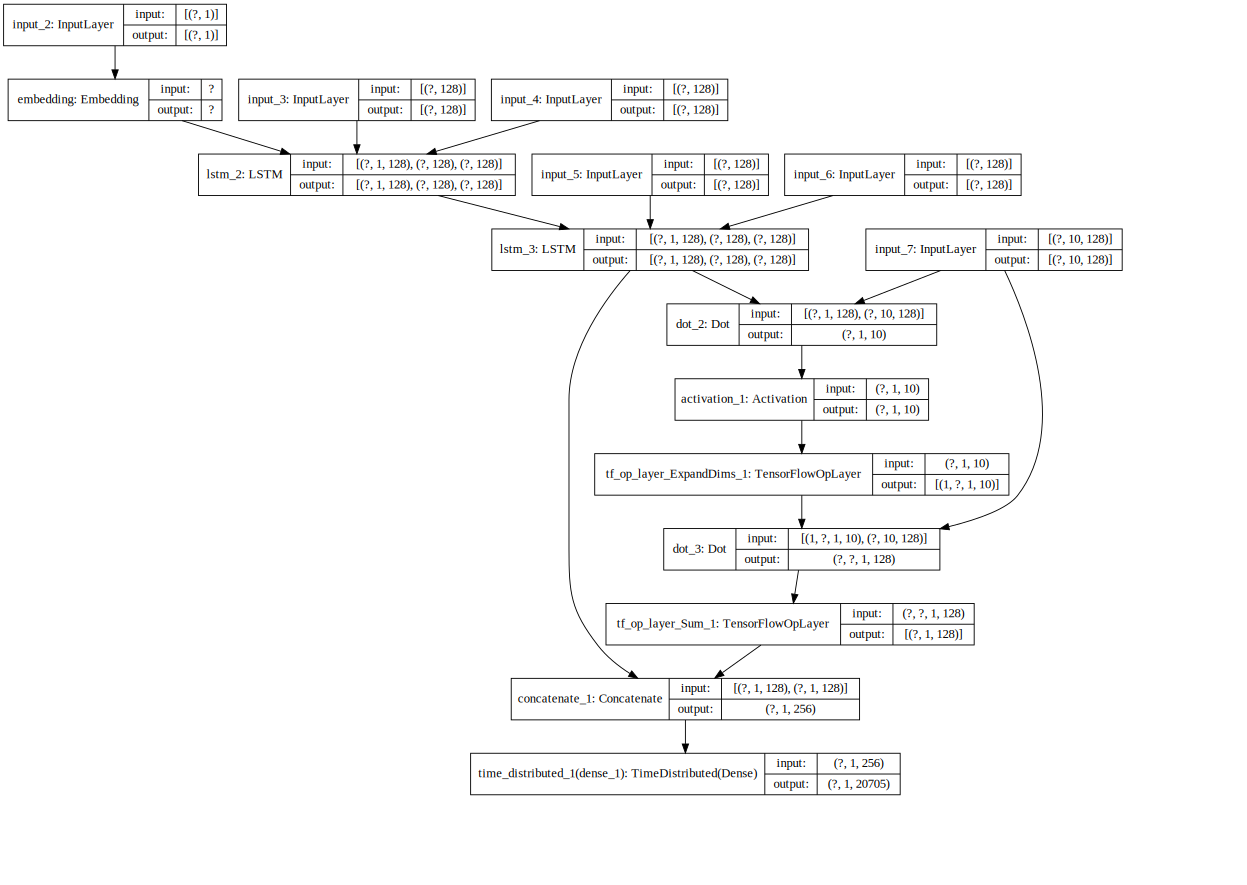

In [18]:
# 디코더 모델
decoder_model = Model([D_input, ih1, ic1, ih2, ic2, ey],
                      [y_output, dh1, dc1, dh2, dc2])
print("========== 디코더 모델 구조 확인 ==========")
print(decoder_model.summary())
SVG(model_to_dot(decoder_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

### Question -> Answer

In [19]:
# question 입력 받아 answer 생성
def genAnswer(question):
    question = question[np.newaxis, :]
    init_h1, init_c1, init_h2, init_c2, enc_y = encoder_model.predict(question)

    # 시작 단어는 <START>로 한다.
    word = np.array(word2idx['<START>']).reshape(1, 1)

    answer = []
    for i in range(MAX_LENGTH):
        dY, next_h1, next_c1, next_h2, next_c2 = \
            decoder_model.predict([word, init_h1, init_c1, init_h2, init_c2, enc_y])
        
        # 디코더의 출력은 vocabulary에 대응되는 one-hot이다.
        # argmax로 해당 단어를 채택한다.
        nextWord = np.argmax(dY[0, 0])
        
        # 예상 단어가 <END>이거나 <PADDING>이면 더 이상 예상할 게 없다.
        if nextWord == word2idx['<END>'] or nextWord == word2idx['<PADDING>']:
            break
        
        # 다음 예상 단어인 디코더의 출력을 answer에 추가한다.
        answer.append(idx2word[nextWord])
        
        # 디코더의 다음 recurrent를 위해 입력 데이터와 hidden 값을
        # 준비한다. 입력은 word이고, hidden은 h와 c이다.
        word = np.array(nextWord).reshape(1,1)
    
        init_h1 = next_h1
        init_c1 = next_c1
        init_h2 = next_h2
        init_c2 = next_c2
        
    return ' '.join(answer)

In [20]:
# Chatting 모델 학습
def chatting(n=100):
    for i in range(n):
        question = input('Q : ')
        
        if  question == 'quit':
            break
        
        q_idx = []
        for x in question.split(' '):
            if x in word2idx:
                q_idx.append(word2idx[x])
            else:
                q_idx.append(word2idx['<UNKNOWN>'])   # out-of-vocabulary (OOV)
        
        # <PADDING>을 삽입한다.
        if len(q_idx) < MAX_LENGTH:
            q_idx.extend([word2idx['<PADDING>']] * (MAX_LENGTH - len(q_idx)))
        else:
            q_idx = q_idx[0:MAX_LENGTH]
        
        answer = genAnswer(np.array(q_idx))
        print('A :', answer)

In [23]:
# 대화 시도: 실패! 오늘도 실패!
chatting(100)

Q : 가끔 궁금해
A : 일하면서 일하면서 일하면서 무뎌지고있나봐 무뎌지고있나봐 기울여주고 기울여주고 기울여주고 옛 옛
Q : 일하고 싶다
A : 생겼네요 생겼네요 보았을까 물건 물건 물건 물건 흘러가네요 흘러가네요 흘러가네요
Q : 무엇이 문제니
A : 받고 받고 축구 축구 물건 물건 물건 편식하는 편식하는 편식하는
Q : 친구야
A : 생겼네요 보았을까 보았을까 보았을까 보았을까 차이일까 차이일까 안되겠지만 됐으면 파혼한거
Q : 정신을 차려봐
A : 받고 받고 받고 축구 않는다면요 착각이 착각이 착각이 들었는데 들었는데
Q : 친구야
A : 생겼네요 보았을까 보았을까 보았을까 보았을까 차이일까 차이일까 안되겠지만 됐으면 파혼한거
Q : 미쳤어?
A : 받고 받고 받고 축구 축구 착각이 물건 물건 편식하는 편식하는
Q : 도대체 너 나한테 왜그러니
A : 굳건히 다음부터 다음부터 상사병 상사병 고치면서 고치면서 고치면서 고치면서 바라야죠
Q : 나랑 싸우자는 거니?
A : 받고 받고 않는다면요 않는다면요 발렌타인데이 발렌타인데이 날려보세요 날려보세요 날려보세요 날려보세요
Q : 날려볼게
A : 받고 받고 받고 축구 축구 착각이 물건 물건 편식하는 편식하는
Q : quit


In [24]:
word2idx

{'<PADDING>': 0,
 '<START>': 1,
 '<END>': 2,
 '<UNKNOWN>': 3,
 '시간이겠네요': 4,
 '과거는': 5,
 '까지': 6,
 '연락은': 7,
 '공통점을': 8,
 '그리운': 9,
 '힘들어져': 10,
 '돌아오고': 11,
 '잠수이별했던': 12,
 '지속해도': 13,
 '고장': 14,
 '물': 15,
 '것이죠': 16,
 '아무렇지도': 17,
 '짝녀는': 18,
 '사랑한걸까': 19,
 '어디': 20,
 '홈쇼핑에서': 21,
 '맘처럼': 22,
 '남음': 23,
 '분하고': 24,
 '되었지만': 25,
 '뿌리면': 26,
 '축복과': 27,
 '타인의': 28,
 '순간을': 29,
 '마지막문자': 30,
 '기를까': 31,
 '해봐': 32,
 '어른인척': 33,
 '팩이나': 34,
 '건방져': 35,
 '자만심': 36,
 '내립니다': 37,
 '내려': 38,
 '좋았어': 39,
 '이별지옥인가봐요': 40,
 '시간이란': 41,
 '농담처럼': 42,
 '계절': 43,
 '죽었나': 44,
 '어떤건지': 45,
 '모르나봐요': 46,
 '고생': 47,
 '식비가': 48,
 '하루': 49,
 '치워보세요': 50,
 '불금에': 51,
 '못했군요': 52,
 '베란다도': 53,
 '결혼적령기예요': 54,
 '무신경해': 55,
 '취향이더라도': 56,
 '가나봐요': 57,
 '친추에': 58,
 '매력이에요': 59,
 '사과': 60,
 '사랑했으니까요': 61,
 '행복의': 62,
 '없어도': 63,
 '잠수가': 64,
 '아프죠': 65,
 '사랑인': 66,
 '감히': 67,
 '변한게': 68,
 '사람들에게': 69,
 '압니다': 70,
 '야구장이나': 71,
 '익숙해지면': 72,
 '두려워지네': 73,
 '만해요': 74,
 '안되네': 75,
 '전화였나봐요': 76,
 '썸타도': 77,
 '끝인': 7

In [25]:
MODEL_PATH

'/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님/Seq2Seq-Chatbot/Seq2Seq_attention.h5'